# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import sys
sys.path.append('/home/olavdc/github/multVI_experiments/scvi_tools/src')

In [3]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi_local
import anndata
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors


/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [5]:
adata = sc.read("/home/olavdc/github/linearSCVI_experiments/data/GSE138852.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 13214 × 10850
    obs: 'batchCond', 'cellType', 'cellType_batchCond', 'subclustID', 'subclustCond'

In [7]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=100, subset=True
)

scvi_local.model.LinearSCVI.setup_anndata(adata, layer="counts")

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [8]:
# Load the autoreload extension
%load_ext autoreload

# Enable automatic reloading of module
%autoreload 2

In [9]:
# initialize LinearSCVI model
model = scvi_local.model.LinearSCVI(
    adata,
    use_batch_norm=False,
    gene_likelihood = "nb",
    n_latent=20)

/home/olavdc/github/multVI_experiments/scvi_tools/src/scvi_local/model/_linear_scvi.py:96: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)


In [10]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="linearSCVI-tests")

In [11]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(
    max_epochs=20, 
    plan_kwargs={"lr": 7e-3},
    logger = wandb_logger,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: olav-declerck (deeplife) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([12


Detected KeyboardInterrupt, attempting graceful shutdown ...


torch.Size([128])
torch.Size([128])


NameError: name 'exit' is not defined

UMAP by cell type

In [20]:
adata.obs.cellType.value_counts()

cellType
oligo      7432
astro      2171
OPC        1078
unID        925
neuron      656
mg          449
doublet     405
endo         98
Name: count, dtype: int64

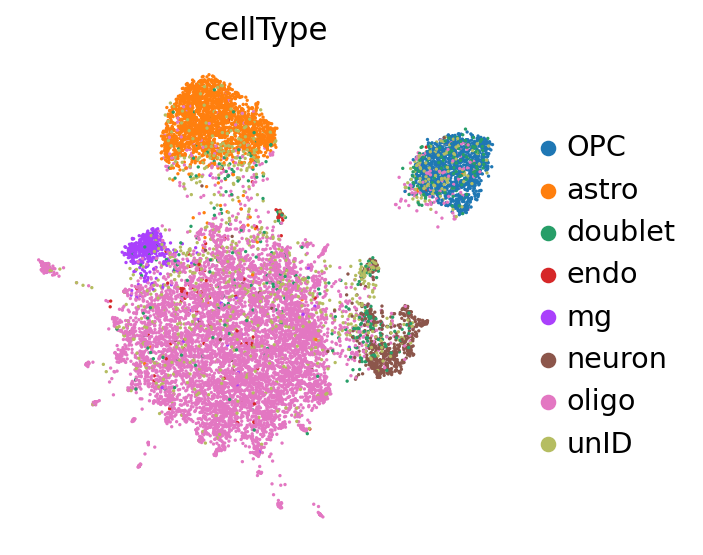

In [27]:
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color="cellType")

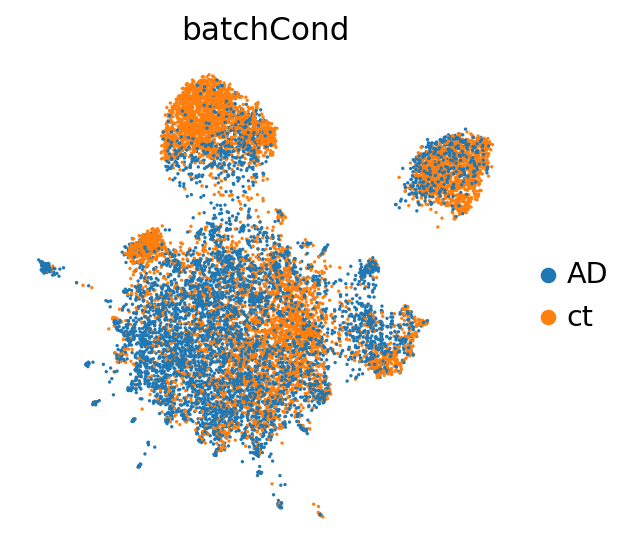

In [28]:
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color="batchCond")

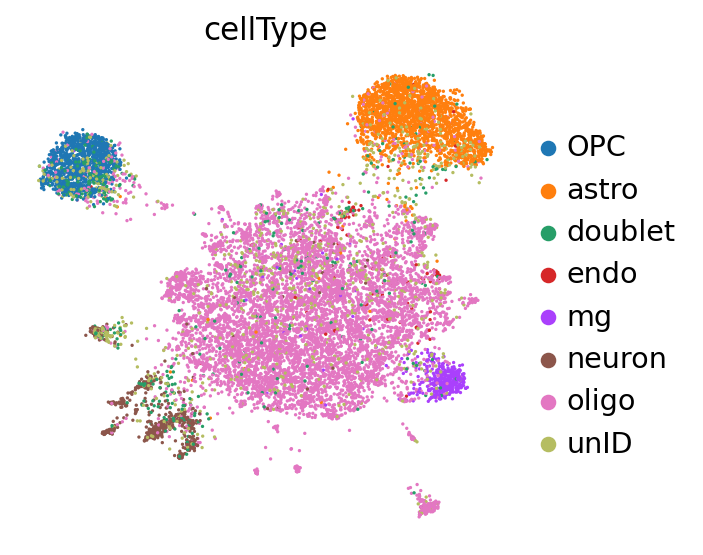

In [16]:
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color="cellType")

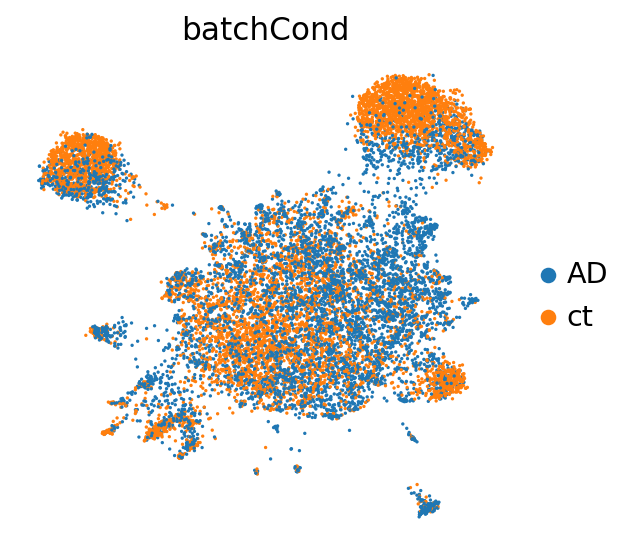

In [22]:
adata.obsm["X_scVI"] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color="batchCond")

Load Z & W

Inspecting the convergence

In [68]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z
Z_df = pd.DataFrame(Z_hat, adata.obs.index)
Z_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AAACCTGGTAGAAAGG_AD5_AD6,2.261557,0.725308,-0.961095,0.630396,-1.447628,-1.061228,-1.283841,0.895787,0.266494,0.284624,0.962841,-0.106692,0.636398,2.702887,-0.819821,-1.764618,0.248379,1.384334,0.702406,-1.287188
AAACCTGGTAGCGATG_AD5_AD6,0.221981,0.388919,0.631296,-1.508109,-1.196654,1.953172,-1.825908,-0.649512,1.179281,0.208972,0.879325,-1.263484,-1.095301,2.319047,-1.149371,-0.084754,0.325081,1.659165,-0.691996,1.571295
AAACCTGTCAGTCAGT_AD5_AD6,-0.188966,1.477681,-0.535868,0.625895,-1.138695,1.432741,-2.754191,-0.105911,0.525520,1.005390,-0.442707,0.349610,0.193964,1.710383,-1.025120,0.333011,1.474508,0.509199,1.375051,-2.289409
AAACCTGTCCAAACAC_AD5_AD6,0.723893,-0.045145,-1.551205,2.362658,-1.460989,1.317864,0.304276,-1.225906,0.629146,-0.744135,0.526128,1.011387,0.260145,0.785869,-0.871763,-1.183898,0.115036,1.595757,-0.522937,-1.544113
AAACCTGTCCAGTATG_AD5_AD6,-0.882227,-0.378497,-1.793262,2.102144,-1.717452,0.806608,-0.831589,1.743290,0.325393,-1.589948,2.059835,-0.502087,0.537569,-0.825205,-0.675176,0.659858,1.379106,-0.033734,-0.572763,-1.791913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,0.061776,0.256353,-0.232759,1.201086,-0.660520,0.125218,0.229451,0.203062,1.959078,0.879693,1.466624,-0.688508,1.213832,0.592813,1.618223,-0.890633,1.770851,0.761570,1.447187,0.772498
TTTGTCACAAGCCATT_AD1_AD2,-0.147958,-2.428311,-0.510347,1.621657,-2.494223,-0.163831,-2.020621,-0.702684,0.992268,0.377770,0.375858,0.492735,-0.756997,1.493857,0.144402,-2.433182,1.281489,-0.365296,1.053208,0.453571
TTTGTCAGTATAGGTA_AD1_AD2,-0.681890,-0.915757,0.030291,0.693273,0.226052,1.489430,-0.841289,-0.877764,-1.099081,-0.657468,-2.307366,-3.498486,1.247452,0.958902,0.787952,-0.090298,1.531770,1.998604,-0.251123,0.958176
TTTGTCATCCACTGGG_AD1_AD2,-1.517893,0.953834,2.371024,-1.205032,-0.971467,0.620287,0.928007,-0.254051,1.434704,-1.541725,-2.009781,-0.976016,-1.409963,0.533310,0.027388,-0.997570,1.802507,0.252956,-0.669589,0.218902


In [69]:
W_df = model.get_loadings()
W_df.index = adata.var.index
W_df

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19
ID3,0.253138,0.197061,0.573816,-0.499988,0.248309,0.295018,-0.014268,-0.080382,-0.685400,-0.520593,0.475850,0.751482,0.044255,0.458483,-0.143895,0.382109,-0.471903,-0.741728,0.701090,0.114603
TNR,-0.006321,-0.085149,-0.521654,0.147326,-0.065306,0.029494,-0.045201,0.136767,0.083579,-0.297779,-0.286042,0.093237,-0.102909,0.080447,-0.419908,-0.039455,-0.256780,0.315942,0.241726,0.227063
RGS1,0.299967,0.275801,-0.015989,-0.620246,0.733172,0.051820,0.060535,-0.399437,-0.228201,-0.423047,-0.043626,-0.356271,-0.287261,-0.028862,0.604834,0.755742,-0.121797,0.099690,-0.587243,0.635058
CFH,0.354678,0.524246,0.261177,-0.558493,0.690678,-0.318294,0.447634,-0.136469,-0.420491,0.230321,0.275123,0.636038,-0.142813,-0.436214,0.360559,0.384889,-0.856881,-0.341337,-0.487106,0.553559
CHI3L1,0.943778,0.254156,0.196199,-0.251787,-0.067664,-0.462502,0.182660,-0.401248,-0.435267,0.123474,0.326662,-0.063158,-0.783160,0.383823,-0.262441,-0.199694,-0.026953,-0.129777,-0.496308,0.221605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JUNB,0.295215,-0.004714,0.346327,-0.607759,0.236704,0.103963,-0.111954,-0.248674,-0.811367,-0.136115,0.546529,0.210758,0.223119,0.054730,0.489115,0.281359,0.262890,0.088699,0.582984,0.157692
APOE,-0.339901,-0.336384,0.676235,-0.138956,-0.393705,0.521053,-0.080661,0.132537,-0.172238,-0.265677,0.344480,-0.498615,0.265900,0.279567,-0.493618,-0.192791,-0.064210,0.621935,-0.218152,0.405650
CLDN5,0.606960,0.692635,0.126076,-0.516851,0.415140,-0.327519,0.330922,-0.388872,-0.594355,-0.266961,0.339564,0.618375,-0.609708,-0.285661,0.305392,0.263721,-0.470408,0.038244,-0.000608,0.408610
GRIK1,-0.532276,-0.118270,-0.139591,-0.132708,0.094353,0.266845,-0.078351,0.022012,0.053469,0.044126,0.182779,0.805482,-0.709502,-0.541076,0.453942,-0.380311,0.236471,-0.119000,-0.181215,0.014270


In [70]:
# Z_df = pd.read_csv("Z_df.csv" , index_col=0)
# W_df = pd.read_csv("W_df.csv", index_col=0)

In [71]:
Z_df = Z_df.add_prefix('z')
# W_df = W_df.add_prefix('z')

In [72]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [73]:
_, variance_explained = Z_covariance(Z_df)
idx = np.argsort(variance_explained)[::-1]

In [74]:
variance_explained

array([0.07408598, 0.06274873, 0.03166411, 0.05819743, 0.05677041,
       0.054973  , 0.04103518, 0.05327176, 0.05239818, 0.04331175,
       0.04431423, 0.04421079, 0.0504475 , 0.04963744, 0.04848206,
       0.04869029, 0.04572077, 0.04643095, 0.04674347, 0.04686597])

In [75]:
Z_df_ordered = pd.DataFrame(Z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = Z_df.index
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = W_df.index

In [76]:
text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}

In [77]:
W_df_ordered["gene_name"] = W_df_ordered.index

In [78]:
W_df_ordered

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,gene_name
ID3,0.253138,0.197061,-0.499988,0.248309,0.295018,-0.080382,-0.685400,0.044255,0.458483,0.382109,...,0.114603,0.701090,-0.741728,-0.471903,0.475850,0.751482,-0.520593,-0.014268,0.573816,ID3
TNR,-0.006321,-0.085149,0.147326,-0.065306,0.029494,0.136767,0.083579,-0.102909,0.080447,-0.039455,...,0.227063,0.241726,0.315942,-0.256780,-0.286042,0.093237,-0.297779,-0.045201,-0.521654,TNR
RGS1,0.299967,0.275801,-0.620246,0.733172,0.051820,-0.399437,-0.228201,-0.287261,-0.028862,0.755742,...,0.635058,-0.587243,0.099690,-0.121797,-0.043626,-0.356271,-0.423047,0.060535,-0.015989,RGS1
CFH,0.354678,0.524246,-0.558493,0.690678,-0.318294,-0.136469,-0.420491,-0.142813,-0.436214,0.384889,...,0.553559,-0.487106,-0.341337,-0.856881,0.275123,0.636038,0.230321,0.447634,0.261177,CFH
CHI3L1,0.943778,0.254156,-0.251787,-0.067664,-0.462502,-0.401248,-0.435267,-0.783160,0.383823,-0.199694,...,0.221605,-0.496308,-0.129777,-0.026953,0.326662,-0.063158,0.123474,0.182660,0.196199,CHI3L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JUNB,0.295215,-0.004714,-0.607759,0.236704,0.103963,-0.248674,-0.811367,0.223119,0.054730,0.281359,...,0.157692,0.582984,0.088699,0.262890,0.546529,0.210758,-0.136115,-0.111954,0.346327,JUNB
APOE,-0.339901,-0.336384,-0.138956,-0.393705,0.521053,0.132537,-0.172238,0.265900,0.279567,-0.192791,...,0.405650,-0.218152,0.621935,-0.064210,0.344480,-0.498615,-0.265677,-0.080661,0.676235,APOE
CLDN5,0.606960,0.692635,-0.516851,0.415140,-0.327519,-0.388872,-0.594355,-0.609708,-0.285661,0.263721,...,0.408610,-0.000608,0.038244,-0.470408,0.339564,0.618375,-0.266961,0.330922,0.126076,CLDN5
GRIK1,-0.532276,-0.118270,-0.132708,0.094353,0.266845,0.022012,0.053469,-0.709502,-0.541076,-0.380311,...,0.014270,-0.181215,-0.119000,0.236471,0.182779,0.805482,0.044126,-0.078351,-0.139591,GRIK1


In [79]:
adata.obs.cellType

AAACCTGGTAGAAAGG_AD5_AD6      oligo
AAACCTGGTAGCGATG_AD5_AD6      oligo
AAACCTGTCAGTCAGT_AD5_AD6      oligo
AAACCTGTCCAAACAC_AD5_AD6      oligo
AAACCTGTCCAGTATG_AD5_AD6      oligo
                             ...   
TTTGGTTTCCGTACAA_AD1_AD2      oligo
TTTGTCACAAGCCATT_AD1_AD2    doublet
TTTGTCAGTATAGGTA_AD1_AD2    doublet
TTTGTCATCCACTGGG_AD1_AD2      oligo
TTTGTCATCCGGGTGT_AD1_AD2    doublet
Name: cellType, Length: 13214, dtype: category
Categories (8, object): ['OPC', 'astro', 'doublet', 'endo', 'mg', 'neuron', 'oligo', 'unID']

['GADD45G' 'BCYRN1' 'CD163' 'CHI3L1' 'NDUFA4L2' 'CLDN5' 'LINC01099'
 'ABCB1']
['GPR183' 'OLR1' 'A2M' 'ADARB2' 'LRRTM4' 'SRGN' 'CCL3' 'HLA-DRA']


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


['FRMD4A' 'MT2A' 'BCYRN1' 'KCNIP4' 'CNTNAP2' 'SYT1' 'GADD45G' 'NRG1']
['BCYRN1' 'CCL2' 'A2M' 'CHI3L1' 'CLDN5' 'JUNB' 'LINC01099' 'ZNF385D']
['SERPINE1' 'IDI1' 'KCNQ5' 'XYLT1' 'CCL3' 'ASIC2' 'RP11-624C23.1' 'CD86']


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


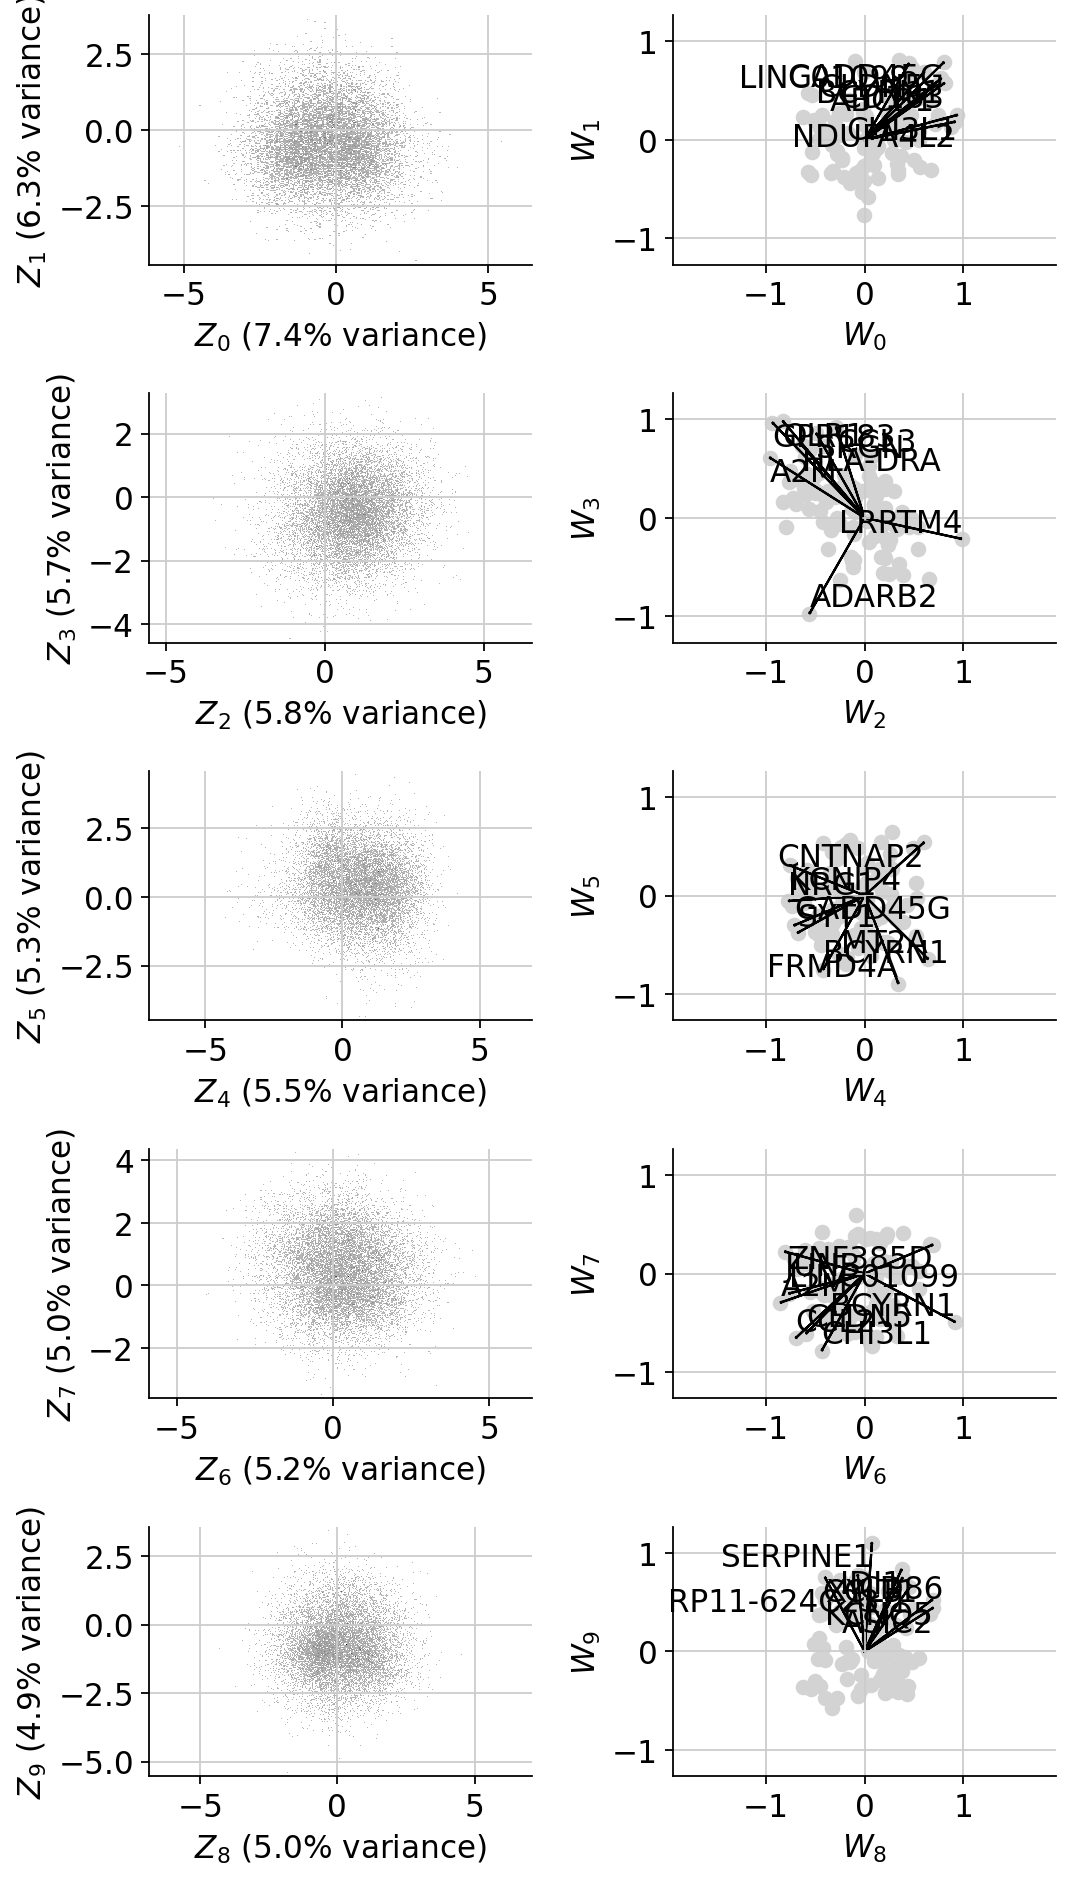

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define figure size
plt.figure(figsize=(7, 12))

# Iterate for each plot
for i in range(5):
    
    # -- Z plot --
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    plt.subplot(5, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right' if x_ > 0 else 'left'
        va = 'top' if y_ > 0 else 'bottom'
        
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='black'))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-2, right=2)
    plt.ylim(bottom=-2, top=2)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to fit plots
plt.tight_layout()

# Save figure as a PDF with high resolution
# plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)


In [155]:
adata = sc.read("/home/olavdc/github/linearSCVI_experiments/data/GSE138852.h5ad")

In [156]:
metadata = adata.obs.loc[Z_df_ordered.index]

In [157]:
metadata = metadata.join(Z_df_ordered)

In [158]:
for ctype in np.unique(metadata['cellType']):
    z_corrs = Z_df_ordered.corrwith((metadata['cellType'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

['z16: +0.34', 'z19: -0.33', ' z5: +0.32'] OPC
['z19: +0.55', ' z0: +0.44', 'z18: -0.43'] astro
[' z4: -0.11', ' z9: -0.07', 'z17: -0.06'] doublet
['z11: +0.10', ' z6: -0.08', ' z8: -0.07'] endo
[' z5: -0.25', ' z2: -0.25', 'z16: -0.24'] mg
[' z4: -0.29', ' z0: -0.27', ' z6: +0.25'] neuron
['z18: +0.36', ' z8: +0.30', ' z1: +0.27'] oligo
[' z4: -0.11', ' z9: -0.08', 'z14: -0.07'] unID


In [159]:
def make_kde(x1, x2):

    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f

In [160]:
from matplotlib import cm
from scipy import stats


In [161]:
vardata = W_df_ordered

In [162]:
top_factors_list = []
for top_factor in top_factors.keys():
    top_factors_list.append(top_factor)

In [163]:
top_factor_pairs

[('z4', 'z9'), ('z4', 'z14'), ('z9', 'z14')]

In [164]:
from itertools import combinations

top_factor_pairs = list(combinations(top_factors_list,2))

In [165]:
metadata.cel

,batchCond,cellType,cellType_batchCond,subclustID,subclustCond,z0,z1,z2,z3,z4,...,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,2.261557,0.725308,0.630396,-1.447628,-1.061228,...,-0.819821,-1.287188,0.702406,1.384334,0.248379,0.962841,-0.106692,0.284624,-1.283841,-0.961095
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0.221981,0.388919,-1.508109,-1.196654,1.953172,...,-1.149371,1.571295,-0.691996,1.659165,0.325081,0.879325,-1.263484,0.208972,-1.825908,0.631296
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,-0.188966,1.477681,0.625895,-1.138695,1.432741,...,-1.025120,-2.289409,1.375051,0.509199,1.474508,-0.442707,0.349610,1.005390,-2.754191,-0.535868
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0.723893,-0.045145,2.362658,-1.460989,1.317864,...,-0.871763,-1.544113,-0.522937,1.595757,0.115036,0.526128,1.011387,-0.744135,0.304276,-1.551205
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,-0.882227,-0.378497,2.102144,-1.717452,0.806608,...,-0.675176,-1.791913,-0.572763,-0.033734,1.379106,2.059835,-0.502087,-1.589948,-0.831589,-1.793262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,AD,oligo,oligo_AD,o3,AD,0.061776,0.256353,1.201086,-0.660520,0.125218,...,1.618223,0.772498,1.447187,0.761570,1.770851,1.466624,-0.688508,0.879693,0.229451,-0.232759
TTTGTCACAAGCCATT_AD1_AD2,AD,doublet,doublet_AD,d2,AD,-0.147958,-2.428311,1.621657,-2.494223,-0.163831,...,0.144402,0.453571,1.053208,-0.365296,1.281489,0.375858,0.492735,0.377770,-2.020621,-0.510347
TTTGTCAGTATAGGTA_AD1_AD2,AD,doublet,doublet_AD,d4,undetermined,-0.681890,-0.915757,0.693273,0.226052,1.489430,...,0.787952,0.958176,-0.251123,1.998604,1.531770,-2.307366,-3.498486,-0.657468,-0.841289,0.030291
TTTGTCATCCACTGGG_AD1_AD2,AD,oligo,oligo_AD,o1,AD,-1.517893,0.953834,-1.205032,-0.971467,0.620287,...,0.027388,0.218902,-0.669589,0.252956,1.802507,-2.009781,-0.976016,-1.541725,0.928007,2.371024


In [173]:
metadata

,batchCond,cellType,cellType_batchCond,subclustID,subclustCond,z0,z1,z2,z3,z4,...,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19
AAACCTGGTAGAAAGG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,2.261557,0.725308,0.630396,-1.447628,-1.061228,...,-0.819821,-1.287188,0.702406,1.384334,0.248379,0.962841,-0.106692,0.284624,-1.283841,-0.961095
AAACCTGGTAGCGATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0.221981,0.388919,-1.508109,-1.196654,1.953172,...,-1.149371,1.571295,-0.691996,1.659165,0.325081,0.879325,-1.263484,0.208972,-1.825908,0.631296
AAACCTGTCAGTCAGT_AD5_AD6,AD,oligo,oligo_AD,o3,AD,-0.188966,1.477681,0.625895,-1.138695,1.432741,...,-1.025120,-2.289409,1.375051,0.509199,1.474508,-0.442707,0.349610,1.005390,-2.754191,-0.535868
AAACCTGTCCAAACAC_AD5_AD6,AD,oligo,oligo_AD,o3,AD,0.723893,-0.045145,2.362658,-1.460989,1.317864,...,-0.871763,-1.544113,-0.522937,1.595757,0.115036,0.526128,1.011387,-0.744135,0.304276,-1.551205
AAACCTGTCCAGTATG_AD5_AD6,AD,oligo,oligo_AD,o3,AD,-0.882227,-0.378497,2.102144,-1.717452,0.806608,...,-0.675176,-1.791913,-0.572763,-0.033734,1.379106,2.059835,-0.502087,-1.589948,-0.831589,-1.793262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCGTACAA_AD1_AD2,AD,oligo,oligo_AD,o3,AD,0.061776,0.256353,1.201086,-0.660520,0.125218,...,1.618223,0.772498,1.447187,0.761570,1.770851,1.466624,-0.688508,0.879693,0.229451,-0.232759
TTTGTCACAAGCCATT_AD1_AD2,AD,doublet,doublet_AD,d2,AD,-0.147958,-2.428311,1.621657,-2.494223,-0.163831,...,0.144402,0.453571,1.053208,-0.365296,1.281489,0.375858,0.492735,0.377770,-2.020621,-0.510347
TTTGTCAGTATAGGTA_AD1_AD2,AD,doublet,doublet_AD,d4,undetermined,-0.681890,-0.915757,0.693273,0.226052,1.489430,...,0.787952,0.958176,-0.251123,1.998604,1.531770,-2.307366,-3.498486,-0.657468,-0.841289,0.030291
TTTGTCATCCACTGGG_AD1_AD2,AD,oligo,oligo_AD,o1,AD,-1.517893,0.953834,-1.205032,-0.971467,0.620287,...,0.027388,0.218902,-0.669589,0.252956,1.802507,-2.009781,-0.976016,-1.541725,0.928007,2.371024


                               z19       z18
AACACGTAGCTGTCTA_AD5_AD6  2.484045 -1.670768
AACCATGTCTGATACG_AD5_AD6  1.430395 -1.782582
AACGTTGGTAAGTTCC_AD5_AD6  2.046802 -2.274554
AACTCAGCACGAAGCA_AD5_AD6  0.279401 -1.856679
AACTCCCGTCTAACGT_AD5_AD6  2.386623 -1.372972
...                            ...       ...
TTAGGCATCGTTGCCT_AD1_AD2 -0.235345 -0.615948
TTCTACAGTTTAGCTG_AD1_AD2  1.807211 -0.710590
TTGCGTCTCTTAGCCC_AD1_AD2  1.328541 -0.112644
TTTATGCGTGCTCTTC_AD1_AD2  1.459516 -2.108684
TTTGCGCGTCACACGC_AD1_AD2  1.775202 -3.648075

[2171 rows x 2 columns]
                               z19       z18
AACTCTTAGAACAATC_AD5_AD6 -0.259808 -0.943166
ACACCCTAGCTACCTA_AD5_AD6 -0.697902 -1.049774
ACACTGACACCTATCC_AD5_AD6 -0.772318 -2.036430
ACCTTTAAGAAACCAT_AD5_AD6 -1.565332 -1.532292
ACCTTTAAGAGTGACC_AD5_AD6 -1.089102 -1.590344
...                            ...       ...
TAGACCACACGAGGTA_AD1_AD2 -0.361914 -0.438964
TAGAGCTCATGAAGTA_AD1_AD2 -1.318244 -1.474901
TATCAGGCATGCCTAA_AD1_AD2  0.38

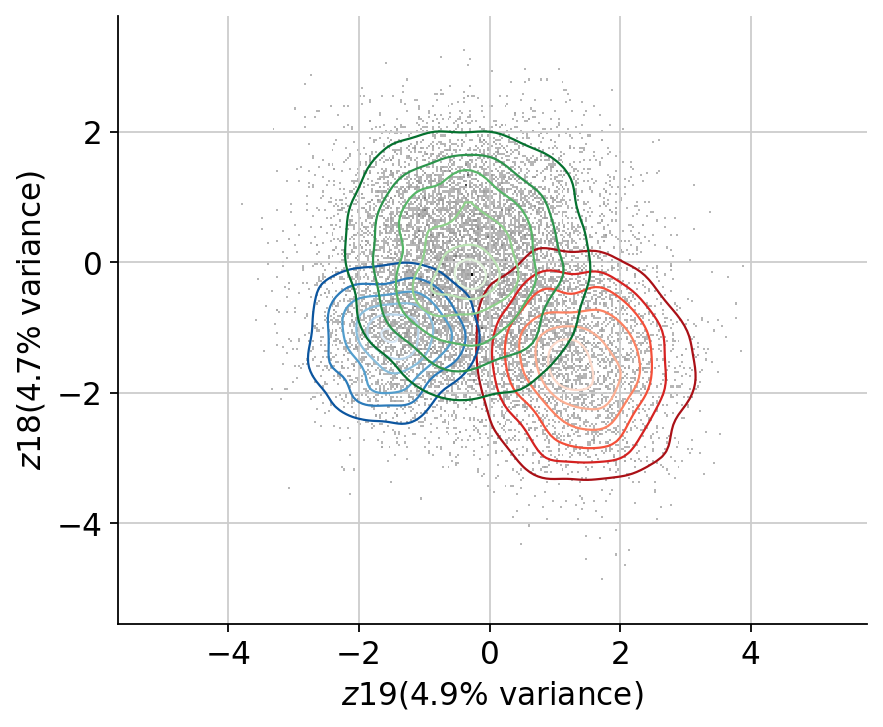

In [174]:
top_factor_1 = 'z19'
top_factor_2 = 'z18'

plt.figure(figsize=(6, 5)) 

plt.hist2d(
    Z_df_ordered[top_factor_1], Z_df_ordered[top_factor_2],
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=cm.gray_r,
    rasterized=True
)

plt.axis('equal')
plt.xlabel(f'${top_factor_1}$' + f'({variance_explained[idx][9]:.1%} variance)')
plt.ylabel(f'${top_factor_2}$' + f'({variance_explained[idx][12]:.1%} variance)')

ax = plt.gca()

color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
conditions = ['astro', 'OPC', 'oligo']

for color, ctype in zip(color_maps, conditions):
    X = metadata.query('cellType == @ctype')[[top_factor_1, top_factor_2]]
    xx1, xx2, f = make_kde(X[top_factor_1], X[top_factor_2])
    cset = ax.contour(
        xx1,
        xx2,
        f,
        levels=6,
        cmap=color,
        linewidths=1.
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered[weight_dim_1], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel(f'${weight_dim_1}$')
# plt.ylabel(f'${weight_dim_2}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

                               z19       z18
AACACGTAGCTGTCTA_AD5_AD6  2.484045 -1.670768
AACCATGTCTGATACG_AD5_AD6  1.430395 -1.782582
AACGTTGGTAAGTTCC_AD5_AD6  2.046802 -2.274554
AACTCAGCACGAAGCA_AD5_AD6  0.279401 -1.856679
AACTCCCGTCTAACGT_AD5_AD6  2.386623 -1.372972
...                            ...       ...
TTAGGCATCGTTGCCT_AD1_AD2 -0.235345 -0.615948
TTCTACAGTTTAGCTG_AD1_AD2  1.807211 -0.710590
TTGCGTCTCTTAGCCC_AD1_AD2  1.328541 -0.112644
TTTATGCGTGCTCTTC_AD1_AD2  1.459516 -2.108684
TTTGCGCGTCACACGC_AD1_AD2  1.775202 -3.648075

[2171 rows x 2 columns]
Empty DataFrame
Columns: [z19, z18]
Index: []


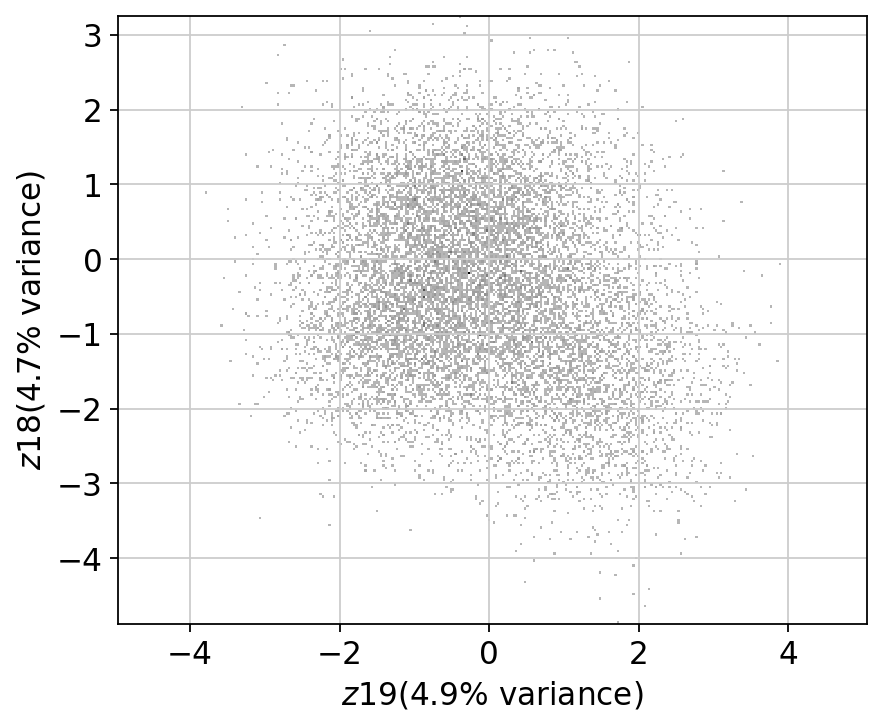

In [166]:
top_factor_1 = 'z19'
top_factor_2 = 'z18'

plt.figure(figsize=(6, 5)) 

plt.hist2d(
    Z_df_ordered[top_factor_1], Z_df_ordered[top_factor_2],
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=cm.gray_r,
    rasterized=True
)

plt.axis('equal')
plt.xlabel(f'${top_factor_1}$' + f'({variance_explained[idx][9]:.1%} variance)')
plt.ylabel(f'${top_factor_2}$' + f'({variance_explained[idx][12]:.1%} variance)')

ax = plt.gca()

color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
conditions = ['astro', 'OPC' 'oligo']

for color, ctype in zip(color_maps, conditions):
    X = metadata.query('cellType == @ctype')[[top_factor_1, top_factor_2]]
    print(X)
    # xx1, xx2, f = make_kde(X[top_factor_1], X[top_factor_2])
    # cset = ax.contour(
    #     xx1,
    #     xx2,
    #     f,
    #     levels=6,
    #     cmap=color,
    #     linewidths=1.
    # )

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered[weight_dim_1], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel(f'${weight_dim_1}$')
# plt.ylabel(f'${weight_dim_2}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

In [ ]:
vardata.sort_values('w9', ascending=False)[['w9', 'gene_name']].head(10)

,w9,gene_name
Rhox5,1.487642,Rhox5
Mt1,1.430507,Mt1
Apoa1,1.289648,Apoa1
Mt2,1.260873,Mt2
Ttr,1.259835,Ttr
Rbp4,1.199056,Rbp4
Apoe,1.186691,Apoe
Apom,1.156252,Apom
Fth1,1.148426,Fth1
Ftl1,1.071174,Ftl1


In [ ]:
vardata.sort_values('w12', ascending=False)[['w12', 'gene_name']].head(10)

,w12,gene_name
Tdgf1,1.682344,Tdgf1
Trh,1.600033,Trh
Psors1c2,1.374456,Psors1c2
Eomes,1.373028,Eomes
Fgf5,1.366540,Fgf5
Pou5f1,1.296097,Pou5f1
Epcam,1.223152,Epcam
Fst,1.206692,Fst
Mixl1,1.197394,Mixl1
Car4,1.177823,Car4


In [ ]:
vardata.sort_values('w12', ascending=False)[['w12', 'gene_name']].tail(10)

,w12,gene_name
Nxpe2,-3.029169,Nxpe2
Slc4a1,-3.098935,Slc4a1
Hba-x,-3.156897,Hba-x
Hsd3b6,-3.458058,Hsd3b6
Hba-a1,-3.475345,Hba-a1
Hba-a2,-3.511914,Hba-a2
Csf2rb,-3.607528,Csf2rb
Hbb-y,-3.721686,Hbb-y
Hbb-bs,-3.758219,Hbb-bs
Hbb-bt,-3.830235,Hbb-bt
